# Customer Segmentation Anlysis

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
from lifetimes.plotting import plot_period_transactions
from plotly.subplots import make_subplots


In [3]:
import scipy
import scipy.sparse
import nltk
import random
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load Data Set

In [4]:
df = pd.read_excel('Data Set\Online Retail.xlsx')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


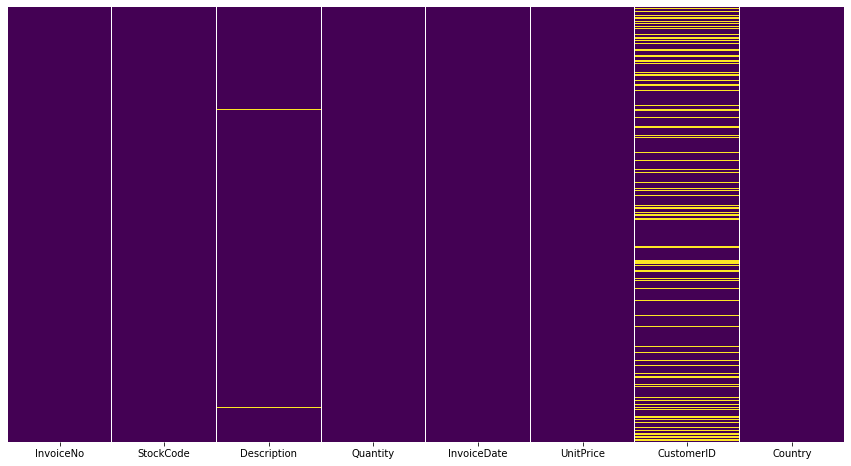

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

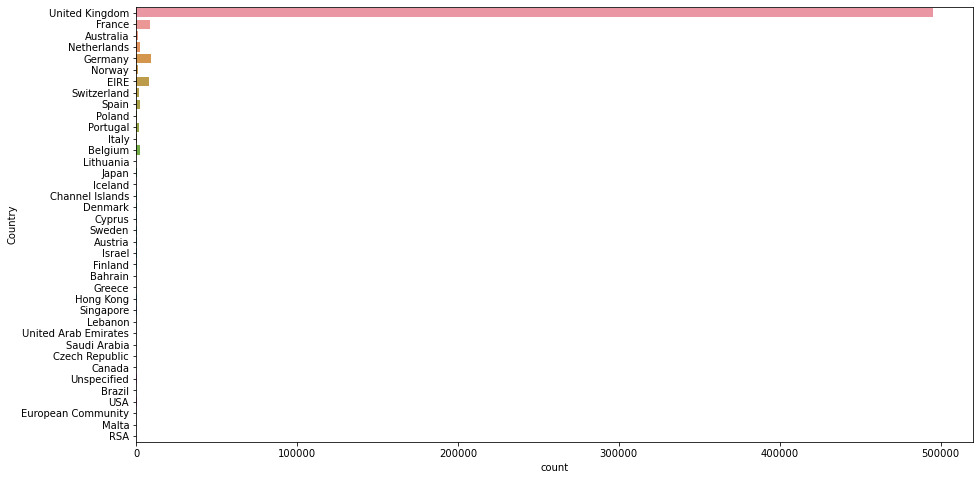

In [8]:
plt.figure(figsize=(15,8))
sns.countplot(y='Country',data=df)

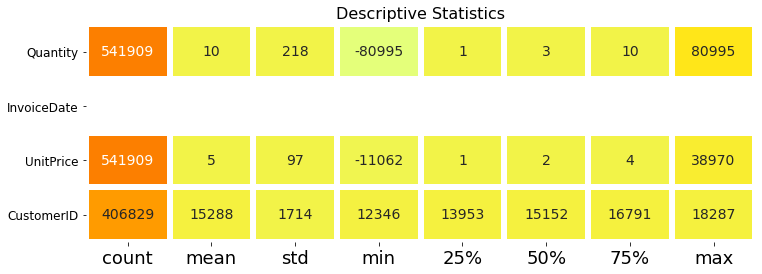

In [9]:
desc = df.describe().T
df1 = pd.DataFrame(index= [col for col in df.columns if df[col].dtype != 'O'], 
                   columns= ["count","mean","std","min","25%","50%","75%","max"],
                   data= desc )

f,ax = plt.subplots(figsize=(12,4))

sns.heatmap(df1, annot=True,cmap = "Wistia", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 14})

plt.xticks(size = 18)
plt.yticks(size = 12, rotation = 0)
plt.title("Descriptive Statistics", size = 16)
plt.show()

# Data Pre Processing

In [10]:
df.dropna(inplace=True)
print('Missing Values: {}'.format(df.isnull().sum().sum()))

Missing Values: 0


In [11]:
df = df[df["Quantity"] > 0]

In [12]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

In [13]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


# RFM Analysis

In [15]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda invoice_date: (today_date - invoice_date.max()).days,
                                    'InvoiceNo': lambda invoice: invoice.nunique(),
                                    'TotalPrice': lambda total_price: total_price.sum()})

rfm.columns = ['recency','frequency','monetary']
rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,326.0
1,12347.0,3,7,3.0
2,12348.0,76,4,76.0
3,12349.0,19,1,19.0
4,12350.0,311,1,311.0


In [16]:
rfm['recency_score'] = pd.qcut(rfm['recency'],5,labels=[5,4,3,2,1])

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"),5,labels=[1,2,3,4,5])

rfm['monetary_score'] = pd.qcut(rfm['monetary'],5,labels=[1,2,3,4,5])

rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str)+ rfm['frequency_score'].astype(str))

In [17]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,326,1,326.0,1,1,5,11,hibernating
1,12347.0,3,7,3.0,5,5,1,55,champions
2,12348.0,76,4,76.0,2,4,4,24,at_Risk
3,12349.0,19,1,19.0,4,1,2,41,promising
4,12350.0,311,1,311.0,1,1,5,11,hibernating


In [18]:
rfm[['recency','monetary','frequency','segment']].groupby('segment').agg({'mean','std','max','min'})

recency                             monetary         \
                        min  max        mean        std      min    max   
segment                                                                   
about_to_sleep           34   72   53.312500  10.943474     34.0   72.0   
at_Risk                  73  374  153.785835  68.618828     73.0  374.0   
cant_loose               73  373  132.968254  65.250378     73.0  373.0   
champions                 1   13    6.361769   3.683300      1.0   13.0   
hibernating              73  374  217.605042  92.013560     73.0  374.0   
loyal_customers          15   72   33.608059  15.577050     15.0   72.0   
need_attention           34   72   52.427807  11.552074     34.0   72.0   
new_customers             1   13    7.428571   3.902112      1.0   13.0   
potential_loyalists       1   33   17.398760   9.338808      1.0   33.0   
promising                15   33   23.421053   5.238115     15.0   33.0   

                                           frequency                  \
                           mean        std       min  max       mean   
segment                                                                
about_to_sleep        53.312500  10.943474         1    2   1.161932   
at_Risk              153.785835  68.618828         2    6   2.878583   
cant_loose           132.968254  65.250378         6   34   8.380952   
champions              6.361769   3.683300         3  210  12.417062   
hibernating          217.605042  92.013560         1    2   1.101774   
loyal_customers       33.608059  15.577050         3   63   6.479853   
need_attention        52.427807  11.552074         2    3   2.326203   
new_customers          7.428571   3.902112         1    1   1.000000   
potential_loyalists   17.398760   9.338808         1    3   2.010331   
promising             23.510638   5.192519         1    1   1.000000   

                                
                           std  
segment                         
about_to_sleep        0.368913  
at_Risk               0.954415  
cant_loose            4.289630  
champions            16.476484  
hibernating           0.302492  
loyal_customers       4.545669  
need_attention        0.470081  
new_customers         0.000000  
potential_loyalists   0.651401  
promising             0.000000

In [19]:
data = go.Bar(y = pd.DataFrame(rfm['segment'].value_counts()).index,
              x = pd.DataFrame(rfm['segment'].value_counts())['segment'].values,
              name = str(pd.DataFrame(rfm['segment'].value_counts())['segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1300])
iplot(fig)

In [20]:
fig = go.Figure()
for i in rfm['segment'].unique():
    fig.add_trace(go.Scatter(x=rfm[rfm['segment']==i]['recency'],
                           y=rfm[rfm['segment']==i]['frequency'],
                           mode='markers', name=str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                  legend=dict(x=0.8,y=1,bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show()

# K-Means Clustering

In [21]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [22]:
kmeans_data = rfm.loc[:,['recency_score','frequency_score']]

inertia=[]
k = [1,2,3,4,5,6,7,8,9]
for i in k:
    kmean=KMeans(n_clusters=i)
    kmean.fit(kmeans_data)
    inertia.append(kmean.inertia_)
    
data = go.Scatter(x=k, y=inertia,mode='lines+markers',marker=dict(size=10))

layout = go.Layout(title={'text': "Elbow Method",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   width=650,height=470,
                   xaxis = dict(title='Number of Clusters'),
                   yaxis =dict(title='Sum of Squared Distance'),
                   template = 'plotly_white')

fig =go.Figure(data=data,layout=layout)
iplot(fig)

In [23]:
kmeans = KMeans(n_clusters = 4,random_state = 42)
kmeans.fit(kmeans_data)
print('Silhouette Score: {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_),3)))

Silhouette Score: 0.483


In [24]:
rfm['k_means_segment'] = kmeans.labels_
rfm['k_means_segment'] = rfm['k_means_segment'].astype(str)
rfm[['recency','monetary','frequency','k_means_segment']].groupby('k_means_segment').agg({'mean','std','max','min'})

recency                             monetary         \
                    min  max        mean        std      min    max   
k_means_segment                                                       
0                    34  373   89.552093  53.760478     34.0  373.0   
1                     1   33   12.951741   9.168522      1.0   33.0   
2                    73  374  220.190751  88.303735     73.0  374.0   
3                     1   72   34.307049  18.763833      1.0   72.0   

                                       frequency                            
                       mean        std       min  max      mean        std  
k_means_segment                                                             
0                 89.552093  53.760478         2   63  4.106134   3.156946  
1                 12.951741   9.168522         2  210  9.203323  12.521359  
2                220.190751  88.303735         1    3  1.227911   0.469831  
3                 34.330144  18.763159         1    3  1.432497   0.618143

In [25]:
data = go.Bar(y = pd.DataFrame(rfm['k_means_segment'].value_counts()).index,
              x = pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values,
              name = str(pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by K-Means Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1900])
iplot(fig)


In [26]:
fig = make_subplots(rows=2,cols=4)

fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='0']['recency'],showlegend=False,
                     name = '0',marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='1']['recency'],showlegend=False,
                     name = '1',marker_color='#EB1919'),row=1,col=2)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='2']['recency'],showlegend=False,
                     name = '2',marker_color='#E8EB19'),row=1,col=3)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='3']['recency'],showlegend=False,
                     name = '3',marker_color='#E8EB19'),row=1,col=4)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='0']['frequency'],showlegend=False,
                     name = '0',marker_color='#1760E1'),row=2,col=1)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='1']['frequency'],showlegend=False,
                     name = '1',marker_color='#EB1919'),row=2,col=2)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='2']['frequency'],showlegend=False,
                     name = '2',marker_color='#E8EB19'),row=2,col=3)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='3']['frequency'],showlegend=False,
                     name = '3',marker_color='#E8EB19'),row=2,col=4)

fig.update_layout(title={'text': "Frequency & Recency by K-Means Segments",'y':0.9,'x':0.5,'xanchor': 'center',
        'yanchor': 'top'},template='plotly')

fig.update_yaxes(title_text="Recency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
iplot(fig)


# Clustomer Lifetime Value

In [27]:
cltv_df = df.groupby('CustomerID').agg({'InvoiceDate': [lambda invoice_date: (invoice_date.max() - invoice_date.min()).days,
                                                        lambda invoice_date: (today_date - invoice_date.min()).days], 
                                        'InvoiceNo': lambda invoice: invoice.nunique(),
                                        'TotalPrice': lambda total_price: total_price.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.0,0,326,1,310.44
12347.0,365,368,7,4310.00
12348.0,282,359,4,1770.78
12349.0,0,19,1,1491.72
12350.0,0,311,1,331.46


In [28]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]


In [29]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [30]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

# BG/NBD Model Forecast

In [31]:
bgf = BetaGeoFitter(penalizer_coef=0.001) #avoid overfitting

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [32]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    3.265158
14911.0    3.126645
17841.0    1.940290
13089.0    1.537528
14606.0    1.463999
15311.0    1.433717
12971.0    1.357024
14646.0    1.222517
13408.0    0.986249
18102.0    0.968607
dtype: float64

In [33]:
bgf.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    13.025670
14911.0    12.473095
17841.0     7.740345
13089.0     6.133456
14606.0     5.840269
15311.0     5.719467
12971.0     5.413481
14646.0     4.876360
13408.0     3.934373
18102.0     3.863856
dtype: float64

In [34]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1777.1450731636928

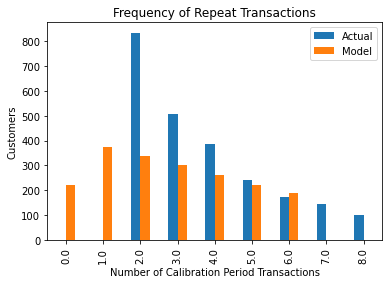

In [35]:
plot_period_transactions(bgf)
plt.show()

In [36]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.80, q: 0.34, v: 3.73>

In [37]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

CustomerID
12415.0    5772.177098
12590.0    5029.408953
12435.0    4288.934927
12409.0    3918.807445
14088.0    3917.128538
18102.0    3870.996680
12753.0    3678.575902
14646.0    3605.309143
15749.0    3216.047938
14096.0    3196.435322
dtype: float64

In [38]:
cltv = ggf.customer_lifetime_value(bgf,cltv_df['frequency'],
                                   cltv_df['recency'],cltv_df['T'],
                                   cltv_df['monetary'],time=6,
                                   freq="W",discount_rate=0.01)

In [39]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,CustomerID,clv
1122,14646.0,108691.797610
2761,18102.0,92510.277355
843,14096.0,56135.699371
36,12415.0,53978.798679
1257,14911.0,53427.083011
2458,17450.0,53004.426445
874,14156.0,45708.064212
2487,17511.0,37047.559984
2075,16684.0,26217.822999
650,13694.0,25301.558007


In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv[["clv"]])
cltv["scaled_clv"] = scaler.transform(cltv[["clv"]])

cltv["segment"] = pd.qcut(cltv["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv.head()

,CustomerID,clv,scaled_clv,segment
0,12347.0,2200.757812,0.020248,A
1,12348.0,1050.352232,0.009664,B
2,12352.0,1007.740705,0.009272,B
3,12356.0,2109.557658,0.019409,A
4,12358.0,1870.554771,0.017210,A


In [41]:
fig = make_subplots(rows=2,
                    cols=2,
                    subplot_titles=("A", "B",'C','D'))

fig.add_trace(go.Box(y =cltv[cltv['segment']=='A']['clv'],showlegend=False,
                     name = 'A',
                     marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='B']['clv'],showlegend=False,
                     name = 'B',
                     marker_color='#1760E1'),row=1,col=2)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='C']['clv'],showlegend=False,
                     name = 'C',
                     marker_color='#1760E1'),row=2,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='D']['clv'],showlegend=False,
                     name = 'D',
                     marker_color='#1760E1'),row=2,col=2)

fig.update_layout(title={'text': "CLTV by SEGMENTS",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly')      
iplot(fig)

In [42]:
data = go.Bar(x = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['segment'],
              y = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],
              text = round(cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],3),
              textposition= 'auto',
              marker = dict(color = 'darkorange'))

layout = go.Layout(title={'text': "Average CLV by Segments",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title='Segment'),
                   yaxis =dict(title='CLV'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_yaxes(range=[0,5100])
iplot(fig)

In [43]:
df = pd.read_excel('Data Set\Online Retail.xlsx')

In [44]:
# Handle cancellation as new feature
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

# Hnadle incorrect Description
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]
df = df[df["Description"].str.contains("LOST") == False]
df = df[df["CustomerID"].notnull()]
df["CustomerID"] = df["CustomerID"].astype(int)

# Convert Invoice Number to integer as we already consider Cancellation as new feature
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

# remove shiping invoices
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]
df.drop("StockCode", inplace=True, axis=1)

# remove outliers by qty
qte_false = [74215, 3114, 80995]  # fond during exploration but not done here (found with a boxplot on qty or price)
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

# Now we can only keep the order without cancellation
df = df[df["Cancelled"] == False]
df.drop("Cancelled", axis=1, inplace=True)

# We can create the feature Price
df["Price"] = df["UnitPrice"] * df["Quantity"]

# convert date to proper datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [45]:
revenue_per_countries = df.groupby(["Country"])["Price"].sum().sort_values()
No_invoice_per_country = df.groupby(["Country"])["InvoiceNo"].count().sort_values()
best_buyer = df.groupby(["Country", "InvoiceNo"])["Price"].sum().reset_index().groupby(["Country"])["Price"].mean().sort_values()

In [46]:
encoder_countries = best_buyer.rank().to_dict()
decoder_countries = {i: j for i, j in encoder_countries.items()}

df["Country"]  = df["Country"].apply(lambda x:encoder_countries[x])

In [47]:
X = df["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = CountVectorizer().build_analyzer()
CV = CountVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter)
TF_matrix = CV.fit_transform(X)
print("TF_matrix :", TF_matrix.shape, "of", TF_matrix.dtype)

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_matrix : (3853, 1686) of int64
TF_IDF_matrix : (3853, 1686) of float64


In [48]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_embedded = svd.fit_transform(TF_matrix)
TF_embedded = normalizer.fit_transform(TF_embedded)
print("TF_embedded :", TF_embedded.shape, "of", TF_embedded.dtype)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_embedded : (3853, 100) of float64
TF_IDF_embedded : (3853, 100) of float64


In [49]:
score_tf = []
score_tfidf = []
mean_tf = []
std_tf = []
mean_tfidf = []
std_tfidf = []


x = list(range(5, 105, 5))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_embedded)
    clusters = kmeans.predict(TF_embedded)
    silhouette_avg = silhouette_score(TF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tf.append(silhouette_avg)
    mean_tf.append(rep.mean())
    std_tf.append(rep.std())

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)
    mean_tfidf.append(rep.mean())
    std_tfidf.append(rep.std())

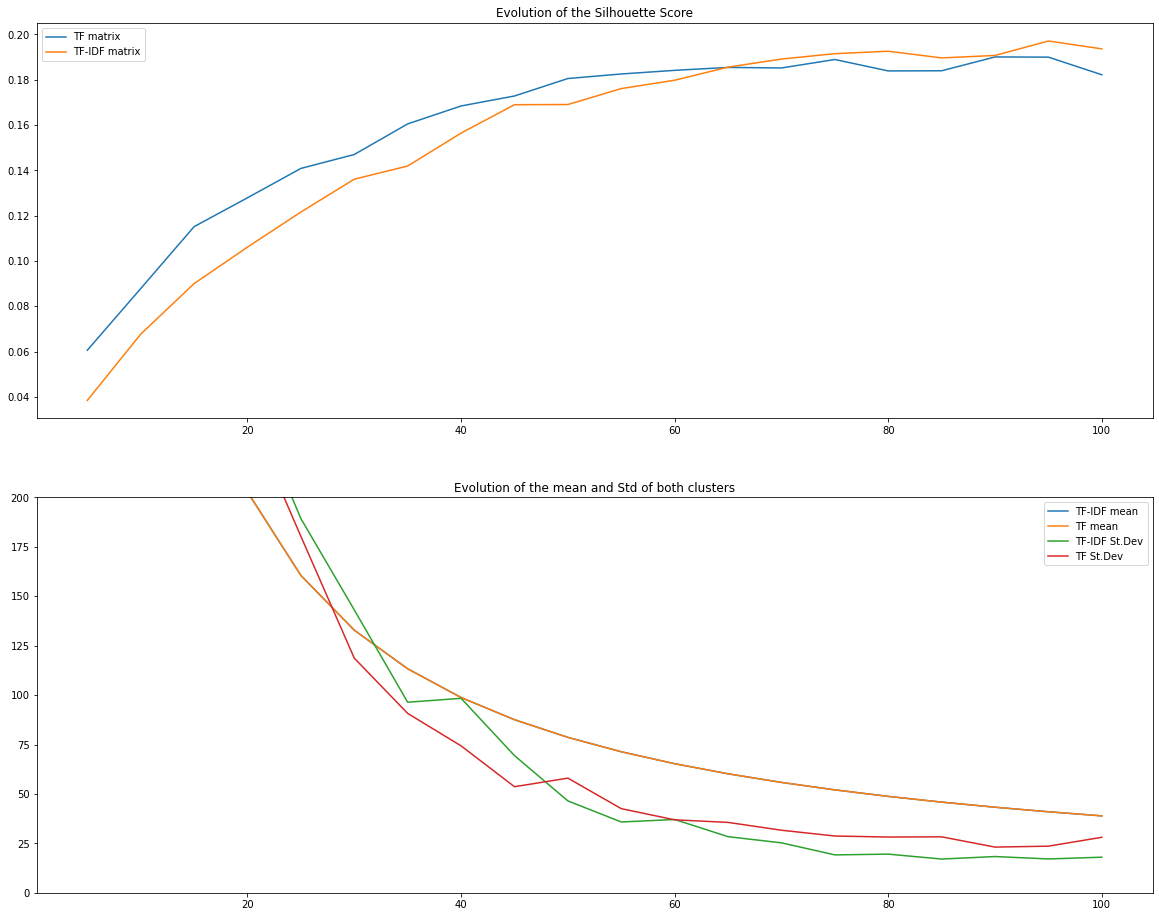

In [50]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tf, label="TF matrix")
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, mean_tfidf, label="TF-IDF mean")
plt.plot(x, mean_tf, label="TF mean")
plt.plot(x, std_tfidf, label="TF-IDF St.Dev")
plt.plot(x, std_tf, label="TF St.Dev")
plt.ylim(0, 200)
plt.title("Evolution of the mean and Std of both clusters")
plt.legend()

plt.show()

In [51]:
n_clusters = 100

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=42)
kmeans.fit(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)

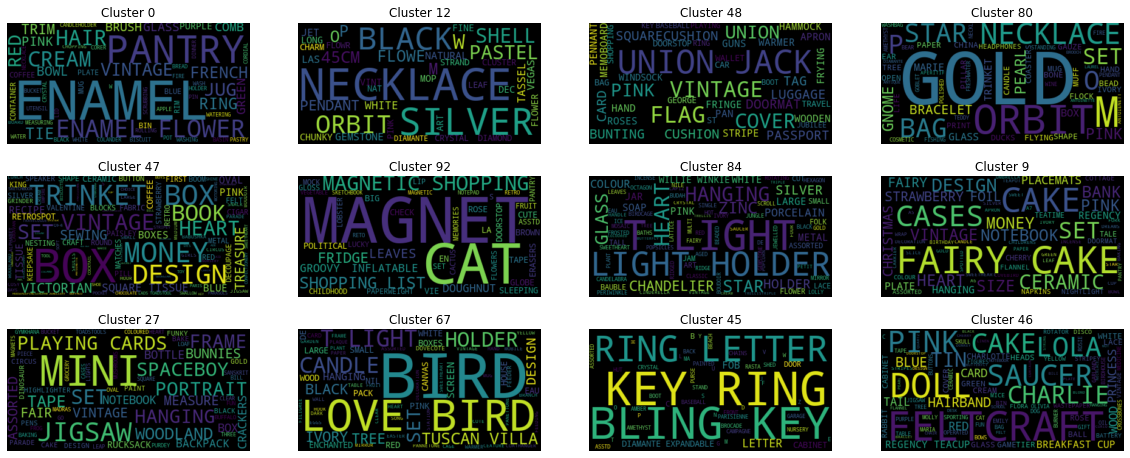

<Figure size 432x288 with 0 Axes>

In [52]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()
plt.show()

In [53]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

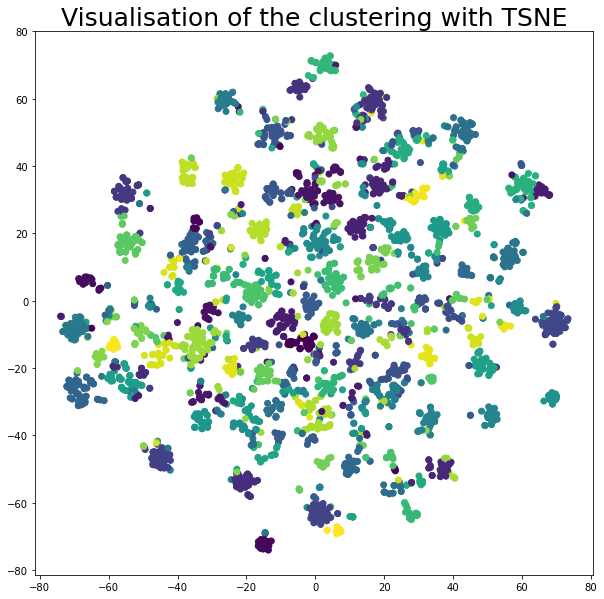

In [54]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

In [55]:
cluster = df['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Article_cluster").mul(df["Price"], 0)
df2 = pd.concat([df['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [56]:
custom_aggregation = {}
custom_aggregation["Price"] = "sum"
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"

df_grouped = df.groupby("InvoiceNo").agg(custom_aggregation)

In [57]:
# let create recency for every Invoice
now = df_grouped["InvoiceDate"].max()  # as the dataset is not done in the present
df_grouped["Recency"] = now - df_grouped["InvoiceDate"]
df_grouped["Recency"] = pd.to_timedelta(df_grouped["Recency"]).astype("timedelta64[D]") # conversion to day from now

# add features required for the next groupby
df_grouped["nb_visit"] = 1
df_grouped["total_spent"] = 1

In [58]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [59]:
custom_aggregation = {}
custom_aggregation["Price"] = ["mean", "sum"]
custom_aggregation["nb_visit"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = ["min", "max"]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [60]:
df_grouped_final["Freq"] = (df_grouped_final["Recency"]["max"]  - df_grouped_final["Recency"]["min"] ) / df_grouped_final["nb_visit"]["sum"]
df_grouped_final.columns = ["avg_price", "sum_price", "nb_visit", "country", "quantity", "min_recency", "max_recency", "freq"]

In [61]:
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
CustomerID,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,1.0,366.0,52.142857
12348,359.310000,1437.24,4,12.0,2332,74.0,357.0,70.750000
12349,1457.550000,1457.55,1,11.0,630,18.0,18.0,0.000000
12350,294.400000,294.40,1,27.0,196,309.0,309.0,0.000000
12352,197.962857,1385.74,7,27.0,526,35.0,296.0,37.285714


In [62]:
X1 = df_grouped_final.values
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

scaler = MinMaxScaler()
X1 = scaler.fit_transform(X1)
X_final_minmax_scale = np.concatenate((X1, X2), axis=1)

In [63]:
x = list(range(2, 10))
y_std = []
y_minmax = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")
    
    kmeans.fit(X_final_minmax_scale)
    clusters = kmeans.predict(X_final_minmax_scale)
    silhouette_avg = silhouette_score(X_final_minmax_scale, clusters)
    y_minmax.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with MinMax Scaling")

n_clusters = 2
The average silhouette_score is : 0.2821846080146957 with Std Scaling
The average silhouette_score is : 0.24458754667304564 with MinMax Scaling
n_clusters = 3
The average silhouette_score is : 0.2882930256023383 with Std Scaling
The average silhouette_score is : 0.2902889466824193 with MinMax Scaling
n_clusters = 4
The average silhouette_score is : 0.3508577263712338 with Std Scaling
The average silhouette_score is : 0.20584483333564657 with MinMax Scaling
n_clusters = 5
The average silhouette_score is : 0.3728692986245063 with Std Scaling
The average silhouette_score is : 0.15831926119329437 with MinMax Scaling
n_clusters = 6
The average silhouette_score is : 0.38188355256977735 with Std Scaling
The average silhouette_score is : 0.14719032717915456 with MinMax Scaling
n_clusters = 7
The average silhouette_score is : 0.36158424273104794 with Std Scaling
The average silhouette_score is : 0.1490562786032718 with MinMax Scaling
n_clusters = 8
The average silhouette_score is

([<matplotlib.axis.XTick at 0x23c7a686040>,
 <a list of 8 Text major ticklabel objects>)

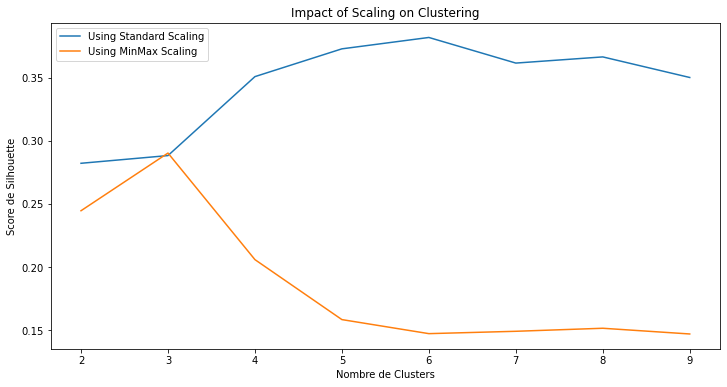

In [64]:
plt.figure(figsize=(12,6))

plt.plot(x, y_std, label="Using Standard Scaling")
plt.plot(x, y_minmax, label="Using MinMax Scaling")

plt.legend()
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.title("Impact of Scaling on Clustering")
plt.xticks(x)


In [65]:
kmeans = KMeans(init='k-means++', n_clusters = 6, n_init=30, random_state=42)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

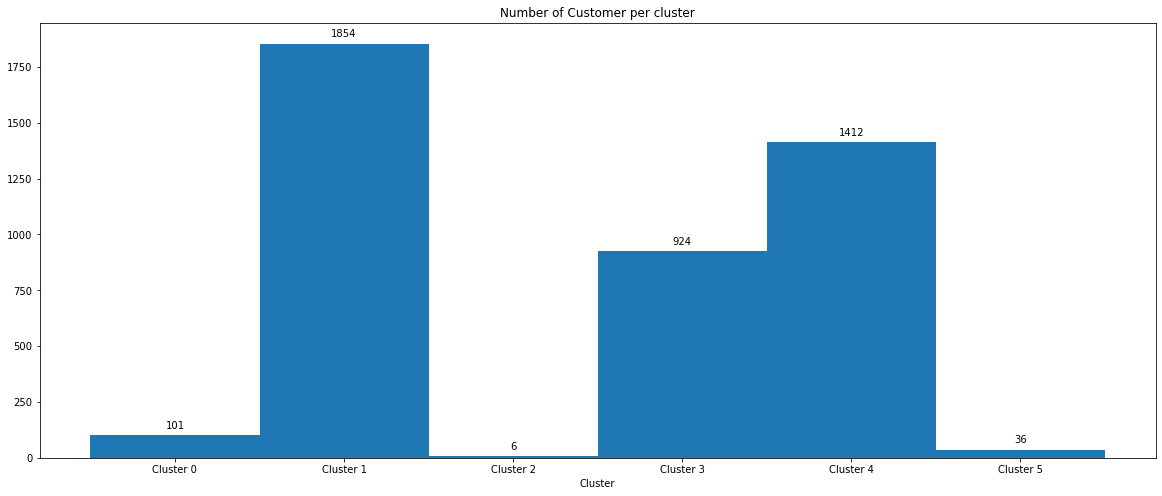

In [66]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=6) # arguments are passed to np.histogram
plt.xlabel("Cluster")
plt.title("Number of Customer per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(6)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

In [67]:
import plotly.express as px

tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

fig = px.scatter(proj, proj[:,0], proj[:,1], color=clusters,
                labels={'color':'clusters'})

fig.update_layout(
    title={
        'text': "Cluster Details",
        'y':1.0,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

fig.write_html(file='myfile.html')

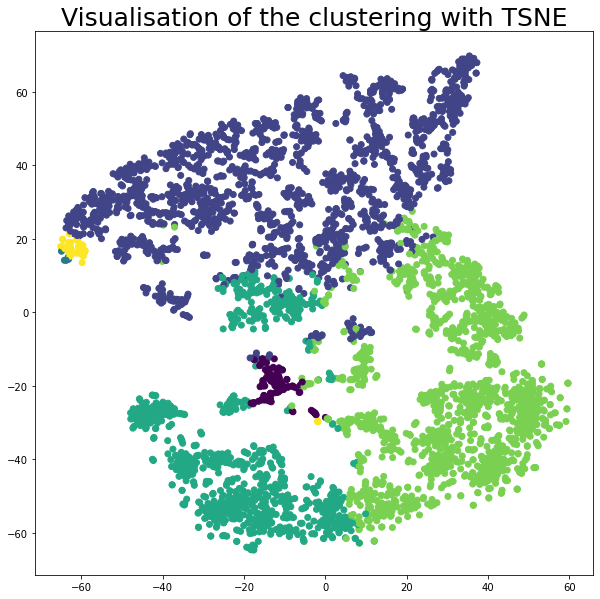

In [68]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

In [69]:
df_grouped_final["cluster"] = clusters
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq,cluster
CustomerID,,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,1.0,366.0,52.142857,1
12348,359.310000,1437.24,4,12.0,2332,74.0,357.0,70.750000,1
12349,1457.550000,1457.55,1,11.0,630,18.0,18.0,0.000000,4
12350,294.400000,294.40,1,27.0,196,309.0,309.0,0.000000,0
12352,197.962857,1385.74,7,27.0,526,35.0,296.0,37.285714,0


In [70]:
df_analysis = df_grouped_final.groupby("cluster").mean()
df_analysis

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
cluster,,,,,,,,
0,1008.753734,2436.389505,2.663366,28.841584,1332.980198,107.267327,216.900990,29.822230
1,358.896079,2347.480016,6.403452,10.211974,1382.869471,41.596009,302.895361,59.309733
2,3574.186403,185895.701667,75.500000,24.833333,91219.666667,6.666667,361.166667,7.152145
3,295.106692,447.111646,1.556277,10.190476,245.896104,257.932900,277.899351,7.286851
4,355.146863,674.127431,1.949717,10.246459,444.189802,49.557365,76.502125,8.691043
5,2128.193650,39226.228889,44.305556,10.611111,24529.111111,23.027778,342.416667,11.144696


#The previous plots highlight the differences between clusters.

The cluster #4 is having a very high mean price (3600 € per basket) and very often (every 5 days). If we take a look at histogramme of number of customer, we can see that this small group of people should be considered as V.I.P. and should be handled like "outliers". In term of history, we can also see that it's old customers and still active so probably happy from our store.

In term of frequency, we can see that there is 2 clusters with also a good frequency but a small basket (#0 and #1). If we take a look at the "history", we can see that it's customer who already purchase few time and we were not able to convert them to frequent customer. Unfortunately, the 2 cluster group more that 2350 customers. They probably join the store for a specific discount.

To finish, if we take a look at the cluster #5 grouping 1850 customers, we can see that they order not very often but in a correct quantity (360€ every 60 days). We should maintain the fidelity of this group as it represent also an important part of the Revenue.

Now let see what every cluster is purchasing

In [71]:
df_analysis1 = df_analysis[['avg_price',"nb_visit",'quantity','freq']]

In [72]:
import plotly.express as px
fig = px.bar(df_analysis1)
fig.update_layout(
    title={
        'text': "Cluster Analysis",
        'y':1.0,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

fig.write_html(file='myfile2.html')